In [1]:
import os
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools
import cv2
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from shutil import copyfile
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
def setseed(seed_value):
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

In [2]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 224
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)
        
def tensor_save_rgbimage(tensor, filename, cuda=False):
    img = tensor.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    img.save(filename)

In [3]:
import zipfile
with zipfile.ZipFile('./PetImages.zip', 'r') as zip_ref:
    zip_ref.extractall('./tmp')

In [4]:
print(len(os.listdir('./tmp/PetImages/Cat/')))
print(len(os.listdir('./tmp/PetImages/Dog/')))

4500
4500


In [5]:
try:
    os.mkdir('./tmp/normal')
    os.mkdir('./tmp/normal/training')
    os.mkdir('./tmp/normal/testing')
    os.mkdir('./tmp/normal/training/cats')
    os.mkdir('./tmp/normal/training/dogs')
    os.mkdir('./tmp/normal/testing/cats')
    os.mkdir('./tmp/normal/testing/dogs')
except OSError:
    pass

try:
    os.mkdir('./tmp/normal+s1/')
    os.mkdir('./tmp/normal+s1/training')
    os.mkdir('./tmp/normal+s1/testing')
    os.mkdir('./tmp/normal+s1/training/cats')
    os.mkdir('./tmp/normal+s1/training/dogs')
    os.mkdir('./tmp/normal+s1/testing/cats')
    os.mkdir('./tmp/normal+s1/testing/dogs')
except OSError:
    pass

In [6]:
stylelist = []
for filename in os.listdir("./style"):
    if filename[0]=='.':
        continue
    stylelist.append(load_img('style/'+filename))

In [7]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE,style = False):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        if not style or np.random.randint(0,4)!=0:
            copyfile(this_file, destination)
        else:
            try:
                content_image = load_img(this_file)
                content_style = stylelist[np.random.randint(0,7)]
                styleimg = hub_model(tf.constant(content_image), tf.constant(content_style))[0]
                cv2.imwrite(destination, np.array(styleimg[0])[:,:,::-1]*255)
            except: 
                print(this_file)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        if not style or np.random.randint(0,4)!=0:
            copyfile(this_file, destination)
        else:
            try:
                content_image = load_img(this_file)
                content_style = stylelist[np.random.randint(7,10)]
                styleimg = hub_model(tf.constant(content_image), tf.constant(content_style))[0]
                cv2.imwrite(destination, np.array(styleimg[0])[:,:,::-1]*255)
            except: 
                print(this_file)

CAT_SOURCE_DIR = "./tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "./tmp/normal/training/cats/"
TESTING_CATS_DIR = "./tmp/normal/testing/cats/"
DOG_SOURCE_DIR = "./tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "./tmp/normal/training/dogs/"
TESTING_DOGS_DIR = "./tmp/normal/testing/dogs/"

S_TRAINING_CATS_DIR = "./tmp/normal+s1/training/cats/"
S_TESTING_CATS_DIR = "./tmp/normal+s1/testing/cats/"
S_TRAINING_DOGS_DIR = "./tmp/normal+s1/training/dogs/"
S_TESTING_DOGS_DIR = "./tmp/normal+s1/testing/dogs/"

In [8]:
# split_size = .8
# split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
# split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)
# split_data(CAT_SOURCE_DIR, S_TRAINING_CATS_DIR, S_TESTING_CATS_DIR, split_size,style = True)
# split_data(DOG_SOURCE_DIR, S_TRAINING_DOGS_DIR, S_TESTING_DOGS_DIR, split_size,style = True)

In [9]:
print(len(os.listdir('./tmp/normal/training/cats/')))
print(len(os.listdir('./tmp/normal/training/dogs/')))
print(len(os.listdir('./tmp/normal/testing/cats/')))
print(len(os.listdir('./tmp/normal/testing/dogs/')))
print(len(os.listdir('./tmp/normal+s1/training/cats/')))
print(len(os.listdir('./tmp/normal+s1/training/dogs/')))
print(len(os.listdir('./tmp/normal+s1/testing/cats/')))
print(len(os.listdir('./tmp/normal+s1/testing/dogs/')))

3600
3600
900
900
3598
3597
899
899


In [10]:
setseed(42)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
setseed(42)
TRAINING_DIR = "./tmp/normal/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.,validation_split=0.2)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150),
                                                    subset='training'
                                                    )
valid_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150),
                                                    subset='validation'
                                                    )

TESTING_DIR = "./tmp/normal/testing/"
test_datagen = ImageDataGenerator(rescale=1.0/255.)
test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                              batch_size=250,
                                                              class_mode='binary',
                                                              target_size=(150, 150),
                                                              )

####################################################
TRAINING_DIR_S1= "./tmp/normal+s1/training/"
train_datagen_S1 = ImageDataGenerator(rescale=1.0/255.,validation_split=0.2)
train_generator_S1 = train_datagen_S1.flow_from_directory(TRAINING_DIR_S1,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150),
                                                    subset='training'
                                                    )
valid_generator_S1 = train_datagen_S1.flow_from_directory(TRAINING_DIR_S1,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150),
                                                    subset='validation'
                                                    )

TESTING_DIR_S1 = "./tmp/normal+s1/testing/"
test_datagen_S1 = ImageDataGenerator(rescale=1.0/255.)
test_generator_S1 = test_datagen_S1.flow_from_directory(TESTING_DIR_S1,
                                                              batch_size=250,
                                                              class_mode='binary',
                                                              target_size=(150, 150),
                                                              )

Found 5760 images belonging to 2 classes.
Found 1440 images belonging to 2 classes.
Found 1800 images belonging to 2 classes.
Found 5757 images belonging to 2 classes.
Found 1438 images belonging to 2 classes.
Found 1798 images belonging to 2 classes.


In [12]:
model1 = tf.keras.models.clone_model(model)
model1.load_weights('normal.h5')
save1 = np.load('history1.npy',allow_pickle='TRUE').item()
model2 = tf.keras.models.clone_model(model)
model2.load_weights('normal+s1.h5')
save2 = np.load('history2.npy',allow_pickle='TRUE').item()

In [13]:
setseed(42)
model1 = tf.keras.models.clone_model(model)
model1.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])
checkpointer = tf.keras.callbacks.ModelCheckpoint('normal.h5',monitor='val_loss', verbose=1, save_best_only=True)
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False),
    checkpointer]
history1 = model1.fit(train_generator, epochs=15,validation_data=valid_generator ,callbacks=callbacks)
save1 = history1.history
np.save('history1.npy',save1)

Epoch 1/15
24/24 [==============================] - ETA: 0s - loss: 0.9568 - acc: 0.5137
Epoch 00001: val_loss improved from inf to 0.69852, saving model to normal.h5
24/24 [==============================] - 98s 4s/step - loss: 0.9568 - acc: 0.5137 - val_loss: 0.6985 - val_acc: 0.5181 - lr: 0.0010
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 0.6830 - acc: 0.5804
Epoch 00002: val_loss improved from 0.69852 to 0.65030, saving model to normal.h5
24/24 [==============================] - 89s 4s/step - loss: 0.6830 - acc: 0.5804 - val_loss: 0.6503 - val_acc: 0.6993 - lr: 0.0010
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 0.6786 - acc: 0.6217
Epoch 00003: val_loss did not improve from 0.65030
24/24 [==============================] - 86s 4s/step - loss: 0.6786 - acc: 0.6217 - val_loss: 0.6510 - val_acc: 0.6889 - lr: 0.0010
Epoch 4/15
24/24 [==============================] - ETA: 0s - loss: 0.6622 - acc: 0.6380
Epoch 00004: val_loss improved from 0

In [14]:
setseed(42)
model2 = tf.keras.models.clone_model(model)
model2.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])
checkpointer = tf.keras.callbacks.ModelCheckpoint('normal+s1.h5',monitor='val_loss', verbose=1, save_best_only=True)
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False),
    checkpointer]
history2 = model2.fit(train_generator_S1, epochs=15,validation_data=valid_generator_S1 ,callbacks=callbacks)
save2 = history2.history
np.save('history2.npy',save2)

Epoch 1/15
24/24 [==============================] - ETA: 0s - loss: 0.9990 - acc: 0.5242
Epoch 00001: val_loss improved from inf to 0.68654, saving model to normal+s1.h5
24/24 [==============================] - 90s 4s/step - loss: 0.9990 - acc: 0.5242 - val_loss: 0.6865 - val_acc: 0.5146 - lr: 0.0010
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 0.6897 - acc: 0.5718
Epoch 00002: val_loss improved from 0.68654 to 0.67335, saving model to normal+s1.h5
24/24 [==============================] - 86s 4s/step - loss: 0.6897 - acc: 0.5718 - val_loss: 0.6733 - val_acc: 0.6314 - lr: 0.0010
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 0.6658 - acc: 0.6153
Epoch 00003: val_loss improved from 0.67335 to 0.64702, saving model to normal+s1.h5
24/24 [==============================] - 86s 4s/step - loss: 0.6658 - acc: 0.6153 - val_loss: 0.6470 - val_acc: 0.6572 - lr: 0.0010
Epoch 4/15
24/24 [==============================] - ETA: 0s - loss: 0.6650 - acc: 0.61

In [15]:
setseed(42)
model1.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])
test_loss, test_acc = model1.evaluate(test_generator)
print('normal trained model with normal test data acc:',test_acc)
model2.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])
test_loss, test_acc = model2.evaluate(test_generator)
print('with some style trained model with normal test data acc:',test_acc)
model1.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])
test_loss, test_acc = model1.evaluate(test_generator_S1)
print('normal trained model with some style test data acc:',test_acc)
model2.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])
test_loss, test_acc = model2.evaluate(test_generator_S1)
print('with some style trained model with some style test data acc:',test_acc)

8/8 [==============================] - 12s 1s/step - loss: 0.5413 - acc: 0.7489
normal trained model with normal test data acc: 0.7488889098167419
8/8 [==============================] - 10s 1s/step - loss: 0.4114 - acc: 0.8133
with some style trained model with normal test data acc: 0.8133333325386047
8/8 [==============================] - 11s 1s/step - loss: 0.4815 - acc: 0.7803
normal trained model with some style test data acc: 0.7803114652633667
8/8 [==============================] - 9s 1s/step - loss: 0.6008 - acc: 0.7186
with some style trained model with some style test data acc: 0.718576192855835


In [16]:
x_test = []
y_test = []
for i in range(8):
    a , b = test_generator.next()
    x_test = [*x_test,*a]
    y_test =  [*y_test,*b]
    print('.',end='')
x_test = np.array(x_test)
y_pred1 = model1.predict(x_test)
y_pred2 = model2.predict(x_test)

........

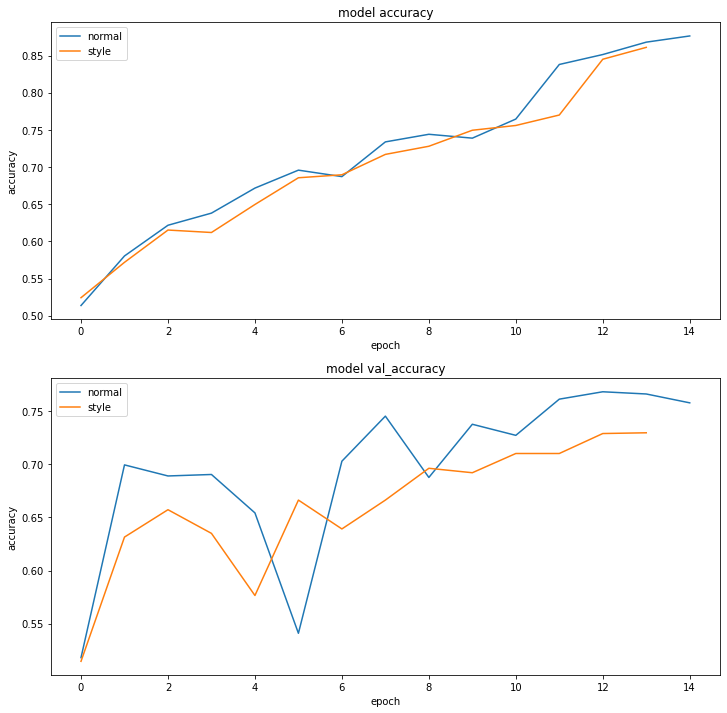

In [19]:
plt.subplot(211)
plt.plot(save1['acc'])
plt.plot(save2['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['normal', 'style'], loc='upper left')
plt.subplot(212)
plt.plot(save1['val_acc'])
plt.plot(save2['val_acc'])
plt.title('model val_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['normal', 'style'], loc='upper left')
plt.show()

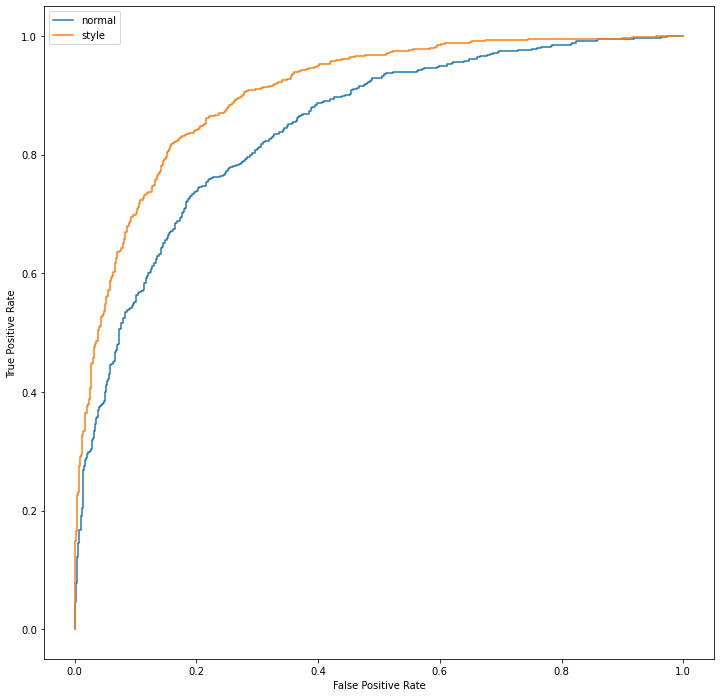

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred1, pos_label=1)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
fpr, tpr, thresholds = roc_curve(y_test, y_pred2, pos_label=1)
plt.plot(fpr,tpr)
plt.legend(['normal', 'style'], loc='upper left')
plt.show()